# Project Contributor
**Vivek Shivakumar**


In [ ]:
from google.colab import files
files.upload()  # This will open a file upload prompt for you to select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vslash23","key":"8907a15da069b57d221e9abc2e52ee6a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
!unzip -qq microsoft-catsvsdogs-dataset.zip -d /content/cats-vs-dogs

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
100% 785M/788M [00:03<00:00, 259MB/s]
100% 788M/788M [00:03<00:00, 215MB/s]


In [ ]:
# Step 2: Preprocess the dataset and remove corrupt images
import os
from PIL import Image

In [ ]:
# Define the path
data_dir = '/content/cats-vs-dogs/PetImages'
for category in ["Cat", "Dog"]:
    folder = os.path.join(data_dir, category)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if it's an image
        except (IOError, SyntaxError) as e:
            print(f"Removing corrupt file: {file_path}")
            os.remove(file_path)

Removing corrupt file: /content/cats-vs-dogs/PetImages/Cat/Thumbs.db
Removing corrupt file: /content/cats-vs-dogs/PetImages/Cat/666.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removing corrupt file: /content/cats-vs-dogs/PetImages/Dog/11702.jpg
Removing corrupt file: /content/cats-vs-dogs/PetImages/Dog/Thumbs.db


In [ ]:
# Step 3: Set up data transforms
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# Step 4: Load the dataset and create train/validation split
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
# Define the split sizes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [ ]:
# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Step 5: Define the model
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final layer for 2 classes
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [ ]:
# Step 6: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Step 7: Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/5, Loss: 0.1741
Epoch 2/5, Loss: 0.1115
Epoch 3/5, Loss: 0.0906
Epoch 4/5, Loss: 0.0750
Epoch 5/5, Loss: 0.0684


In [ ]:
# Step 8: Evaluate the model on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Validation Accuracy: 96.52%


In [ ]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 1: Collect predictions and actual labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


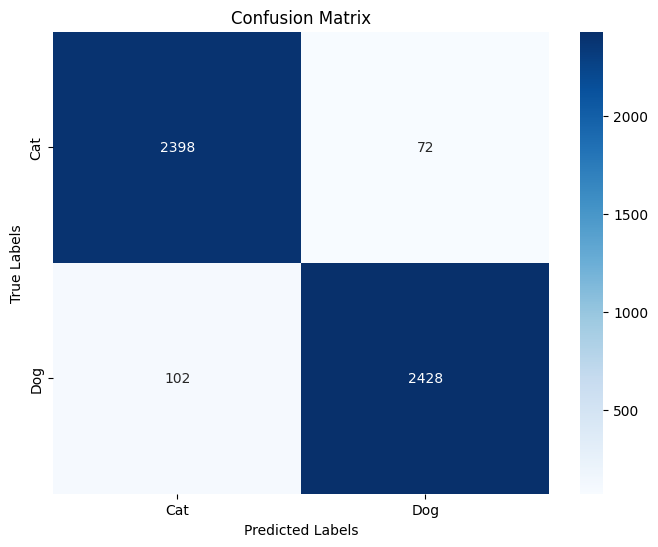

In [ ]:
# Step 2: Calculate Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Step 3: Calculate Classification Report
report = classification_report(all_labels, all_preds, target_names=["Cat", "Dog"], digits=4)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         Cat     0.9592    0.9709    0.9650      2470
         Dog     0.9712    0.9597    0.9654      2530

    accuracy                         0.9652      5000
   macro avg     0.9652    0.9653    0.9652      5000
weighted avg     0.9653    0.9652    0.9652      5000



### Methods and Results

For Question 3, we fine-tuned a pre-trained ResNet18 model to classify images of cats and dogs from the Kaggle Cats vs. Dogs dataset. We adapted the model by adjusting the final layer to output two classes, representing cats and dogs. The dataset was split into training and testing sets, with the model trained for several epochs using the cross-entropy loss function and the Adam optimizer.

After training, we evaluated the model’s performance using a confusion matrix, accuracy, F1-score, precision, and recall. The model achieved an accuracy of **96.52%** on the test set, with strong precision and recall values across both classes, as reflected in the classification report. The confusion matrix showed minimal misclassifications, indicating that the model accurately distinguished between cats and dogs. This demonstrates the effectiveness of transfer learning with ResNet18 in performing binary image classification tasks with limited training adjustments.
